## Partial Dependence (PDP) and Individual Conditional Expectation (ICE) plots

In this example, we train a classification model with the Adult Census Income dataset. Then we treat the model as a blackbox model and calculate the PDP and ICE plots for some selected categorical and numeric features. 

This dataset can be used to predict whether annual income exceeds $50,000/year or not based on demographic data from the 1994 U.S. Census. The dataset we're reading contains 32,561 rows and 14 columns/features.

[More info on the dataset here](https://archive.ics.uci.edu/ml/datasets/Adult)

We will train a classification model with a target - income >= 50K.

---

**Partial Dependence Plot (PDP) ** function at a particular feature value represents the average prediction if we force all data points to assume that feature value.

**Individual Conditional Expectation (ICE)** plots display one line per instance that shows how the instance’s prediction changes when a feature changes. One line represents the predictions for one instance if we vary the feature of interest.

PDP and ICE plots visualize and help to analyze the interaction between the target response and a set of input features of interest. It is essential when you are building a Machine Learning model to understand model behavior and how certain features influences overall prediction. One of the most popular use-cases is analyzing feature importance.

---
Python dependencies:

matplotlib==3.2.2

numpy==1.19.2

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
import pyspark.sql.functions as F
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from synapse.ml.explainers import ICETransformer

import matplotlib.pyplot as plt

### Read and prepare the dataset

In [0]:
df = spark.read.parquet("wasbs://publicwasb@mmlspark.blob.core.windows.net/AdultCensusIncome.parquet")
df.show(20)

+---+-------------+------+-------------+-------------+--------------------+------------------+---------------+-------------------+-------+------------+------------+--------------+--------------+------+
age| workclass|fnlwgt| education|education-num| marital-status| occupation| relationship| race| sex|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+-------------+------+-------------+-------------+--------------------+------------------+---------------+-------------------+-------+------------+------------+--------------+--------------+------+
 45| Private|362883| HS-grad| 9| Married-civ-spouse| Craft-repair| Husband| White| Male| 5013| 0| 40.0| United-States| <=50K|
 43| Private|182757| HS-grad| 9| Married-civ-spouse| Craft-repair| Husband| White| Male| 0| 0| 40.0| United-States| >50K|
 20| Private| 50397| HS-grad| 9| Never-married| Adm-clerical| Own-child| Black| Male| 0| 0| 20.0| United-States| <=50K|
 43| Federal-gov|101709| Some-college| 10| Divorced| Handlers-cleaners| Not-in-family| Asian-Pac-Islander| Male| 0| 0| 40.0| United-States| <=50K|
 21| Private|202570| 12th| 8| Never-married| Adm-clerical| Other-relative| Black| Male| 0| 0| 48.0| ?| <=50K|
 40| Private|145649| HS-grad| 9| Separated| Sales| Unmarried| Black| Female| 0| 0| 25.0| United-States| <=50K|
 36| Private|136343| Bachelors| 13| Married-civ-spouse| Prof-specialty| Husband| White| Male| 0| 0| 40.0| United-States| >50K|
 64| Self-emp-inc|142166| Bachelors| 13| Divorced| Sales| Not-in-family| White| Male| 0| 0| 45.0| United-States| <=50K|
 19| ?|242001| Some-college| 10| Never-married| ?| Own-child| White| Female| 0| 0| 40.0| United-States| <=50K|
 46| Private|127089| Some-college| 10| Married-civ-spouse| Prof-specialty| Husband| White| Male| 5178| 0| 38.0| United-States| >50K|
 46| Local-gov|124071| Masters| 14| Divorced| Exec-managerial| Unmarried| White| Female| 0| 0| 65.0| United-States| >50K|
 41| Local-gov|190368| Bachelors| 13| Never-married| Prof-specialty| Not-in-family| White| Female| 0| 0| 70.0| United-States| <=50K|
 29| ?| 19793| Some-college| 10| Divorced| ?| Unmarried| White| Female| 0| 0| 8.0| United-States| <=50K|
 28| Private| 67661| Some-college| 10| Never-married| Adm-clerical| Other-relative| White| Female| 0| 0| 40.0| United-States| <=50K|
 23| Private| 62278| Some-college| 10| Married-civ-spouse| Sales| Husband| White| Male| 0| 0| 45.0| United-States| <=50K|
 30| Federal-gov|295010| Bachelors| 13| Never-married| Protective-serv| Not-in-family| White| Female| 0| 0| 60.0| United-States| >50K|
 44| Private|203897| Bachelors| 13| Married-spouse-a...| Adm-clerical| Not-in-family| White| Female| 0| 0| 40.0| Cuba| <=50K|
 27| Private|265314| HS-grad| 9| Married-civ-spouse| Transport-moving| Husband| White| Male| 0| 0| 45.0| United-States| >50K|
 25| Private|159603| HS-grad| 9| Never-married| Other-service| Unmarried| White| Female| 0| 0| 34.0| United-States| <=50K|
 29| Private|134331| 10th| 6| Married-civ-spouse| Craft-repair| Husband| White| Male| 0| 0| 40.0| United-States| <=50K|
+---+-------------+------+-------------+-------------+--------------------+------------------+---------------+-------------------+-------+------------+------------+--------------+--------------+------+
only showing top 20 rows

In [0]:
categorical_features = ["race", "workclass", "marital-status", "education", "occupation", "relationship", "native-country", "sex"]
numeric_features = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
string_indexer_outputs = [feature + "_idx" for feature in categorical_features]
one_hot_encoder_outputs = [feature + "_enc" for feature in categorical_features]

pipeline = Pipeline(stages=[
    StringIndexer().setInputCol("income").setOutputCol("label").setStringOrderType("alphabetAsc"),
    StringIndexer().setInputCols(categorical_features).setOutputCols(string_indexer_outputs),
    OneHotEncoder().setInputCols(string_indexer_outputs).setOutputCols(one_hot_encoder_outputs),
    VectorAssembler(inputCols=one_hot_encoder_outputs+numeric_features, outputCol="features"),
    GBTClassifier(weightCol="fnlwgt")])

In [0]:
display(df.groupBy("education-num").count())

education-num,count
7,1175
6,933
9,10501
5,514
1,51
10,7291
3,333
12,1067
8,433
11,1382


### Fit the model and view the predictions

In [0]:
model = pipeline.fit(df)

Check that model makes sense and has reasonable output. For this, we will check the model performance by calculating the ROC-AUC score.

In [0]:
data = model.transform(df)
display(data.select('income', 'probability', 'prediction'))

income,probability,prediction
<=50K,"Map(vectorType -> dense, length -> 2, values -> List(0.3885489128506902, 0.6114510871493097))",1.0
>50K,"Map(vectorType -> dense, length -> 2, values -> List(0.6854230495343593, 0.3145769504656407))",0.0
<=50K,"Map(vectorType -> dense, length -> 2, values -> List(0.9547583167612279, 0.04524168323877209))",0.0
<=50K,"Map(vectorType -> dense, length -> 2, values -> List(0.9336046155934876, 0.06639538440651238))",0.0
<=50K,"Map(vectorType -> dense, length -> 2, values -> List(0.9443949232167498, 0.05560507678325022))",0.0
<=50K,"Map(vectorType -> dense, length -> 2, values -> List(0.9470380567783225, 0.052961943221677465))",0.0
>50K,"Map(vectorType -> dense, length -> 2, values -> List(0.3080355701930437, 0.6919644298069563))",1.0
<=50K,"Map(vectorType -> dense, length -> 2, values -> List(0.6949767838147618, 0.3050232161852382))",0.0
<=50K,"Map(vectorType -> dense, length -> 2, values -> List(0.9547583167612279, 0.04524168323877209))",0.0
>50K,"Map(vectorType -> dense, length -> 2, values -> List(0.23175272445718556, 0.7682472755428145))",1.0


In [0]:
eval_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
eval_auc.evaluate(data)

Out[13]: 0.780067883880639

## PDP

\\(X_S\\) - set of input features of interest, \\(X_C\\) - its complement.

The partial dependence of the response \\(f\\) at a point \\(x_S\\) is defined as:

$$ pd_{X_S}(x_S) = \mathsf{E} X_C [f(x_S, X_C)] = \int f(x_S, x_C) p(x_C)dx_C$$

where \\(f(x_S, x_C)\\)  is the response function for a given sample whose values are defined by \\(x_S\\) for the features in \\(X_S\\) (i.e. the features you want to explain), and by \\(x_C\\) for the features in \\(X_C\\) (i.e. features that are not being analyzed).

The compuation method estimates the above integaral by computing an average over the dataset \\(X\\):

$$pd_{X_S}(x_S) \approx \frac{1}{n_{samples}} \sum_{i=1}^n f(x_S, x_C^{(i)}) $$

where \\(x_C^{(i)}\\) is the value of the i-th sample for the features in \\(X_C\\). For each value of \\(x_S\\), this method requires a full pass over the dataset \\(X\\).

---

We will show how features "sex", "education", "worklass", "occupation" (categorical feautures) and "education-num" and "age" (numeric features) affect the prediction of the income exceeds $50,000/year.

--- 

Source: https://christophm.github.io/interpretable-ml-book/pdp.html

### Setup the transformer for PDP

In [0]:
pdp = ICETransformer(model=model, targetCol="probability", kind="average", targetClasses=[1],
                     categoricalFeatures=categorical_features, numericFeatures=numeric_features, numSamples=50)

PDP is a spark transformer, the function **transform** returns the schema of (1 row * number features to explain) which contains dependence for the given feature in a format: feature_value -> dependence (in our case probability).

In [0]:
output_pdp = pdp.transform(df)
display(output_pdp)

race_dependence,workclass_dependence,marital-status_dependence,education_dependence,occupation_dependence,relationship_dependence,native-country_dependence,sex_dependence,age_dependence,education-num_dependence,capital-gain_dependence,capital-loss_dependence,hours-per-week_dependence
"Map( Black -> Map(vectorType -> dense, length -> 1, values -> List(0.2682215472365688)), White -> Map(vectorType -> dense, length -> 1, values -> List(0.2694564870154187)), Asian-Pac-Islander -> Map(vectorType -> dense, length -> 1, values -> List(0.2691709039667144)), Other -> Map(vectorType -> dense, length -> 1, values -> List(0.2682215472365688)), Amer-Indian-Eskimo -> Map(vectorType -> dense, length -> 1, values -> List(0.2658762236695464)))","Map( ? -> Map(vectorType -> dense, length -> 1, values -> List(0.26825476433815115)), Self-emp-inc -> Map(vectorType -> dense, length -> 1, values -> List(0.27522980838188854)), Self-emp-not-inc -> Map(vectorType -> dense, length -> 1, values -> List(0.2625068050675441)), Private -> Map(vectorType -> dense, length -> 1, values -> List(0.26825476433815115)), Federal-gov -> Map(vectorType -> dense, length -> 1, values -> List(0.28522205246374877)), Local-gov -> Map(vectorType -> dense, length -> 1, values -> List(0.269846559108017)), Without-pay -> Map(vectorType -> dense, length -> 1, values -> List(0.26825476433815115)), Never-worked -> Map(vectorType -> dense, length -> 1, values -> List(0.26825476433815115)), State-gov -> Map(vectorType -> dense, length -> 1, values -> List(0.2675734066841757)))","Map( Married-civ-spouse -> Map(vectorType -> dense, length -> 1, values -> List(0.39885600114011005)), Divorced -> Map(vectorType -> dense, length -> 1, values -> List(0.19121172117616755)), Never-married -> Map(vectorType -> dense, length -> 1, values -> List(0.19087196757728353)), Separated -> Map(vectorType -> dense, length -> 1, values -> List(0.19436540273972938)), Widowed -> Map(vectorType -> dense, length -> 1, values -> List(0.19121172117616755)), Married-spouse-absent -> Map(vectorType -> dense, length -> 1, values -> List(0.19121172117616755)), Married-AF-spouse -> Map(vectorType -> dense, length -> 1, values -> List(0.19121172117616755)))","Map( HS-grad -> Map(vectorType -> dense, length -> 1, values -> List(0.2723264957289368)), 9th -> Map(vectorType -> dense, length -> 1, values -> List(0.27328397277525246)), Assoc-voc -> Map(vectorType -> dense, length -> 1, values -> List(0.2741696854451636)), 10th -> Map(vectorType -> dense, length -> 1, values -> List(0.27811587272990185)), 7th-8th -> Map(vectorType -> dense, length -> 1, values -> List(0.27328397277525246)), Assoc-acdm -> Map(vectorType -> dense, length -> 1, values -> List(0.2760945364376869)), Some-college -> Map(vectorType -> dense, length -> 1, values -> List(0.2753503637687803)), 1st-4th -> Map(vectorType -> dense, length -> 1, values -> List(0.27328397277525246)), 11th -> Map(vectorType -> dense, length -> 1, values -> List(0.27328397277525246)), Preschool -> Map(vectorType -> dense, length -> 1, values -> List(0.27328397277525246)), 5th-6th -> Map(vectorType -> dense, length -> 1, values -> List(0.27328397277525246)), Doctorate -> Map(vectorType -> dense, length -> 1, values -> List(0.28061007810809674)), 12th -> Map(vectorType -> dense, length -> 1, values -> List(0.2756460421535072)), Prof-school -> Map(vectorType -> dense, length -> 1, values -> List(0.27328397277525246)), Bachelors -> Map(vectorType -> dense, length -> 1, values -> List(0.26696424790534695)), Masters -> Map(vectorType -> dense, length -> 1, values -> List(0.2706721870031746)))","Map( Armed-Forces -> Map(vectorType -> dense, length -> 1, values -> List(0.25139172465872456)), ? -> Map(vectorType -> dense, length -> 1, values -> List(0.25139172465872456)), Sales -> Map(vectorType -> dense, length -> 1, values -> List(0.2560605233314231)), Exec-managerial -> Map(vectorType -> dense, length -> 1, values -> List(0.3173565773021301)), Craft-repair -> Map(vectorType -> 

### Visualization

In [0]:
# Helper functions for visualization

def get_pandas_df_from_column(df, col_name):
  keys_df = df.select(F.explode(F.map_keys(F.col(col_name)))).distinct()
  keys = list(map(lambda row: row[0], keys_df.collect()))
  key_cols = list(map(lambda f: F.col(col_name).getItem(f).alias(str(f)), keys))
  final_cols = key_cols
  pandas_df = df.select(final_cols).toPandas()
  return pandas_df

def plot_dependence_for_categorical(df, col, col_int=True, figsize=(20, 5)):
  dict_values = {}
  col_names = list(df.columns)

  for col_name in col_names:
    dict_values[col_name] = df[col_name][0].toArray()[0]
    marklist= sorted(dict_values.items(), key=lambda x: int(x[0]) if col_int else x[0]) 
    sortdict=dict(marklist)

  fig = plt.figure(figsize = figsize)
  plt.bar(sortdict.keys(), sortdict.values())

  plt.xlabel(col, size=13)
  plt.ylabel("Dependence")
  plt.show()
  
def plot_dependence_for_numeric(df, col, col_int=True, figsize=(20, 5)):
  dict_values = {}
  col_names = list(df.columns)

  for col_name in col_names:
    dict_values[col_name] = df[col_name][0].toArray()[0]
    marklist= sorted(dict_values.items(), key=lambda x: int(x[0]) if col_int else x[0]) 
    sortdict=dict(marklist)

  fig = plt.figure(figsize = figsize)

  
  plt.plot(list(sortdict.keys()), list(sortdict.values()))

  plt.xlabel(col, size=13)
  plt.ylabel("Dependence")
  plt.ylim(0.0)
  plt.show()
  

#### Example 1: "Age"

We can observe non-linear dependency. Income rapidly grows from 24-38 age, after 58 it slightly drops and from 68 remains stable.

In [0]:
display(output_pdp)

race_dependence,workclass_dependence,marital-status_dependence,education_dependence,occupation_dependence,relationship_dependence,native-country_dependence,sex_dependence,age_dependence,education-num_dependence,capital-gain_dependence,capital-loss_dependence,hours-per-week_dependence
"Map( Black -> Map(vectorType -> dense, length -> 1, values -> List(0.2682215472365688)), White -> Map(vectorType -> dense, length -> 1, values -> List(0.2694564870154187)), Asian-Pac-Islander -> Map(vectorType -> dense, length -> 1, values -> List(0.2691709039667144)), Other -> Map(vectorType -> dense, length -> 1, values -> List(0.2682215472365688)), Amer-Indian-Eskimo -> Map(vectorType -> dense, length -> 1, values -> List(0.2658762236695464)))","Map( ? -> Map(vectorType -> dense, length -> 1, values -> List(0.26825476433815115)), Self-emp-inc -> Map(vectorType -> dense, length -> 1, values -> List(0.27522980838188854)), Self-emp-not-inc -> Map(vectorType -> dense, length -> 1, values -> List(0.2625068050675441)), Private -> Map(vectorType -> dense, length -> 1, values -> List(0.26825476433815115)), Federal-gov -> Map(vectorType -> dense, length -> 1, values -> List(0.28522205246374877)), Local-gov -> Map(vectorType -> dense, length -> 1, values -> List(0.269846559108017)), Without-pay -> Map(vectorType -> dense, length -> 1, values -> List(0.26825476433815115)), Never-worked -> Map(vectorType -> dense, length -> 1, values -> List(0.26825476433815115)), State-gov -> Map(vectorType -> dense, length -> 1, values -> List(0.2675734066841757)))","Map( Married-civ-spouse -> Map(vectorType -> dense, length -> 1, values -> List(0.39885600114011005)), Divorced -> Map(vectorType -> dense, length -> 1, values -> List(0.19121172117616755)), Never-married -> Map(vectorType -> dense, length -> 1, values -> List(0.19087196757728353)), Separated -> Map(vectorType -> dense, length -> 1, values -> List(0.19436540273972938)), Widowed -> Map(vectorType -> dense, length -> 1, values -> List(0.19121172117616755)), Married-spouse-absent -> Map(vectorType -> dense, length -> 1, values -> List(0.19121172117616755)), Married-AF-spouse -> Map(vectorType -> dense, length -> 1, values -> List(0.19121172117616755)))","Map( HS-grad -> Map(vectorType -> dense, length -> 1, values -> List(0.2723264957289368)), 9th -> Map(vectorType -> dense, length -> 1, values -> List(0.27328397277525246)), Assoc-voc -> Map(vectorType -> dense, length -> 1, values -> List(0.2741696854451636)), 10th -> Map(vectorType -> dense, length -> 1, values -> List(0.27811587272990185)), 7th-8th -> Map(vectorType -> dense, length -> 1, values -> List(0.27328397277525246)), Assoc-acdm -> Map(vectorType -> dense, length -> 1, values -> List(0.2760945364376869)), Some-college -> Map(vectorType -> dense, length -> 1, values -> List(0.2753503637687803)), 1st-4th -> Map(vectorType -> dense, length -> 1, values -> List(0.27328397277525246)), 11th -> Map(vectorType -> dense, length -> 1, values -> List(0.27328397277525246)), Preschool -> Map(vectorType -> dense, length -> 1, values -> List(0.27328397277525246)), 5th-6th -> Map(vectorType -> dense, length -> 1, values -> List(0.27328397277525246)), Doctorate -> Map(vectorType -> dense, length -> 1, values -> List(0.28061007810809674)), 12th -> Map(vectorType -> dense, length -> 1, values -> List(0.2756460421535072)), Prof-school -> Map(vectorType -> dense, length -> 1, values -> List(0.27328397277525246)), Bachelors -> Map(vectorType -> dense, length -> 1, values -> List(0.26696424790534695)), Masters -> Map(vectorType -> dense, length -> 1, values -> List(0.2706721870031746)))","Map( Armed-Forces -> Map(vectorType -> dense, length -> 1, values -> List(0.25139172465872456)), ? -> Map(vectorType -> dense, length -> 1, values -> List(0.25139172465872456)), Sales -> Map(vectorType -> dense, length -> 1, values -> List(0.2560605233314231)), Exec-managerial -> Map(vectorType -> dense, length -> 1, values -> List(0.3173565773021301)), Craft-repair -> Map(vectorType -> 

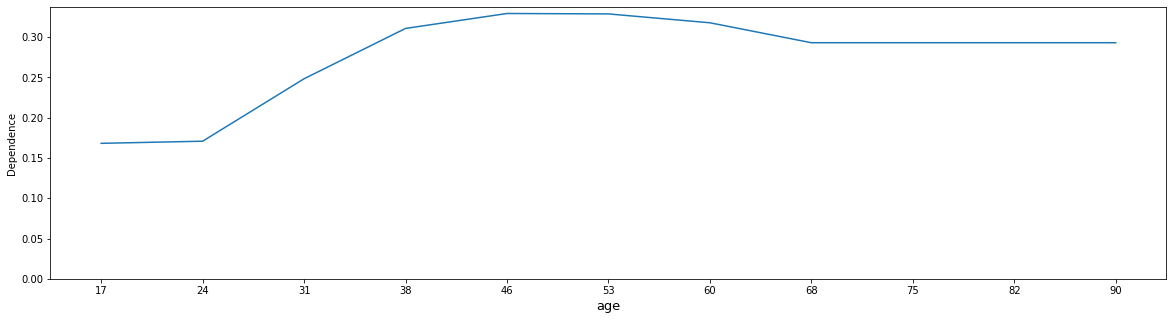

In [0]:
df_education_num = get_pandas_df_from_column(output_pdp, 'age_dependence')
plot_dependence_for_numeric(df_education_num, 'age')

#### Example 2: "marital-status"

According to the result, the model treats "married-cv-spouse" as one category and all others as a second category. It looks reasonable, taking into account that GBT has a tree structure.

If the model picks "divorced" as one category and the rest features as the second category- then most likely there is an error and some bias in data.

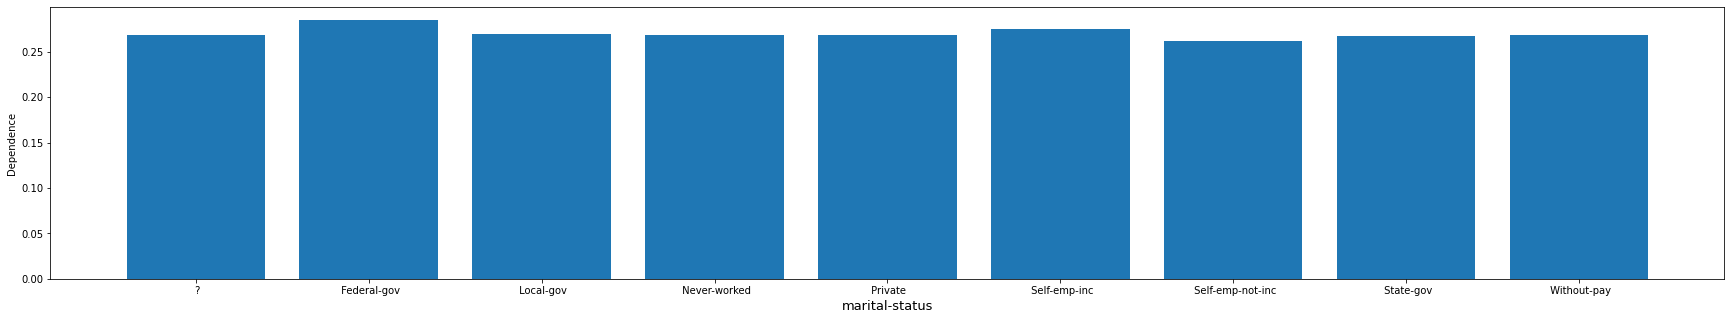

In [0]:
df_occupation = get_pandas_df_from_column(output_pdp, 'workclass_dependence')
plot_dependence_for_categorical(df_occupation, 'marital-status', False, figsize=(30, 5))

#### Example 3: "capital-gain"

Firstly we run PDP with default parameters for rangeMin and rangeMax. We can see that this representation is not useful, it is not granulated enough, because it was dynamically computed from the data. That is why we set rangeMin = 0 and rangeMax = 10000 to visualize more granulated interpretations for the part we're interested in.

On the second graph we can observe how capital-gain affects the dependence.

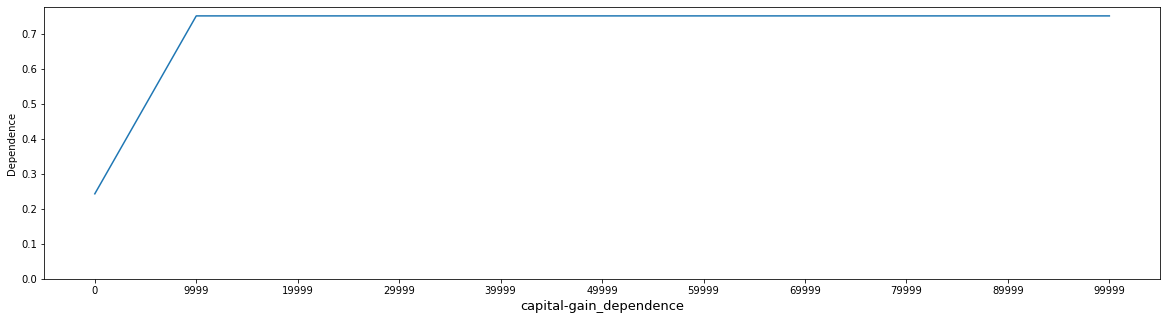

In [0]:
df_education_num = get_pandas_df_from_column(output_pdp, 'capital-gain_dependence')
plot_dependence_for_numeric(df_education_num, 'capital-gain_dependence')

In [0]:
pdp_cap_gain = ICETransformer(model=model, targetCol="probability", kind="average", targetClasses=[1], 
                              numericFeatures=[{"name": "capital-gain", "numSplits": 20, "rangeMin": 0.0,
                                                 "rangeMax": 10000.0}], numSamples=50)

output_pdp_cap_gain = pdp_cap_gain.transform(df)

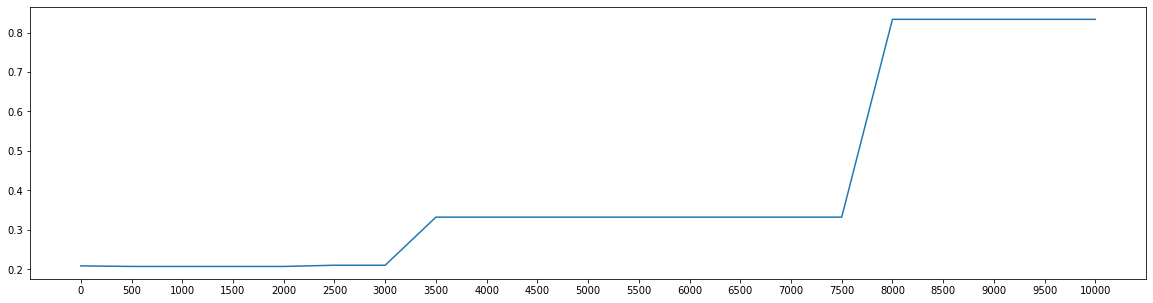

In [0]:
df_education_num_gain = get_pandas_df_from_column(output_pdp_cap_gain, 'capital-gain_dependence')
plot_dependence_for_numeric(df_education_num_gain, 'capital-gain_dependence')

### Conclusions

**Advantages:**

1) Plots is intuitive.

2) PDPs perfectly represent how the feature influences the prediction on average (for not correlated features).

3) Plots are easy to implement.

**Disadvantages:**

1) The realistic maximum number of features in a partial dependence function is two.

2) Some PD plots do not show the feature distribution.

3) The assumption of independence is the biggest issue with PD plots.

4) PD plots only show the average marginal effects.

## ICE

\\(X_S\\) - set of input features of interest, \\(X_C\\) - its complement.


The equivalent to a PDP for individual data instances is called individual conditional expectation (ICE) plot. A PDP is the average of the lines of an ICE plot.

The values for a line (and one instance) can be computed by keeping all other features the same, creating variants of this instance by replacing the feature’s value with values from a grid and making predictions with the black box model for these newly created instances. 

For each instance in $$ \{ (x_{S}^{(i)},x_{C}^{(i)}) \}_{i=1}^N$$ the curve \\(\hat{f}_S^{(i)}\\) is plotted against \\(x_S^{(i)} \\), while \\( x_C^{(i)}\\) remains fixed.

---


We will show the same features as for PDP to show a difference: "sex", "education", "worklass", "occupation" (categorical feautures) and "education-num" and "age" (numeric features)

---
Source: https://christophm.github.io/interpretable-ml-book/ice.html

### Setup the transformer for ICE

In [0]:
ice = ICETransformer(model=model, targetCol="probability", targetClasses=[1], 
                     categoricalFeatures=categorical_features, numericFeatures=numeric_features, numSamples=50)

In [0]:
output = ice.transform(df)
display(output)

age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,targetClasses,race_dependence,workclass_dependence,marital-status_dependence,education_dependence,occupation_dependence,relationship_dependence,native-country_dependence,sex_dependence,age_dependence,education-num_dependence,capital-gain_dependence,capital-loss_dependence,hours-per-week_dependence
44,Private,260761,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40.0,United-States,>50K,List(1),"Map( Black -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), White -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Asian-Pac-Islander -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Other -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Amer-Indian-Eskimo -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)))","Map( ? -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Self-emp-inc -> Map(vectorType -> dense, length -> 1, values -> List(0.35182840822976535)), Self-emp-not-inc -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Private -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Federal-gov -> Map(vectorType -> dense, length -> 1, values -> List(0.4053618018273498)), Local-gov -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Without-pay -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Never-worked -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), State-gov -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)))","Map( Married-civ-spouse -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Divorced -> Map(vectorType -> dense, length -> 1, values -> List(0.05957453841508875)), Never-married -> Map(vectorType -> dense, length -> 1, values -> List(0.05957453841508875)), Separated -> Map(vectorType -> dense, length -> 1, values -> List(0.05957453841508875)), Widowed -> Map(vectorType -> dense, length -> 1, values -> List(0.05957453841508875)), Married-spouse-absent -> Map(vectorType -> dense, length -> 1, values -> List(0.05957453841508875)), Married-AF-spouse -> Map(vectorType -> dense, length -> 1, values -> List(0.05957453841508875)))","Map( HS-grad -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), 9th -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Assoc-voc -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), 10th -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), 7th-8th -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Assoc-acdm -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Some-college -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), 1st-4th -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), 11th -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Preschool -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), 5th-6th -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Doctorate -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), 12th -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Prof-school -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Bachelors -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), Masters -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)))","Map( Armed-Forces -> Map(vectorType -> dense, length -> 1, values -> List(0.3322556663960602)), ? -> Map(vectorType -> d

### Visualization

In [0]:
# Helper functions for visualization
from math import pi

from collections import defaultdict

def plot_ice_numeric(df, col, col_int=True, figsize=(20, 10)):
  dict_values = defaultdict(list)
  col_names = list(df.columns)
  num_instances = df.shape[0]
  
  instances_y = {}
  i = 0

  for col_name in col_names:
    for i in range(num_instances):
      dict_values[i].append(df[col_name][i].toArray()[0])
  
  fig = plt.figure(figsize = figsize)
  for i in range(num_instances):
    plt.plot(col_names, dict_values[i], "k")
  
  
  plt.xlabel(col, size=13)
  plt.ylabel("Dependence")
  plt.ylim(0.0)
  
  
  
def plot_ice_categorical(df, col, col_int=True, figsize=(20, 10)):
  dict_values = defaultdict(list)
  col_names = list(df.columns)
  num_instances = df.shape[0]
  
  angles = [n / float(df.shape[1]) * 2 * pi for n in range(df.shape[1])]
  angles += angles [:1]
  
  instances_y = {}
  i = 0

  for col_name in col_names:
    for i in range(num_instances):
      dict_values[i].append(df[col_name][i].toArray()[0])
  
  fig = plt.figure(figsize = figsize)
  ax = plt.subplot(111, polar=True)
  plt.xticks(angles[:-1], col_names)
  
  for i in range(num_instances):
    values = dict_values[i]
    values += values[:1]
    ax.plot(angles, values, "k")
    ax.fill(angles, values, 'teal', alpha=0.1)

  plt.xlabel(col, size=13)
  plt.show()
    

#### Example 1: Numeric feature: "Age"

All curves seem to follow the same course, so there are no obvious interactions. That means that the PDP is already a good summary of the relationships between the displayed features and the predicted income >=50K

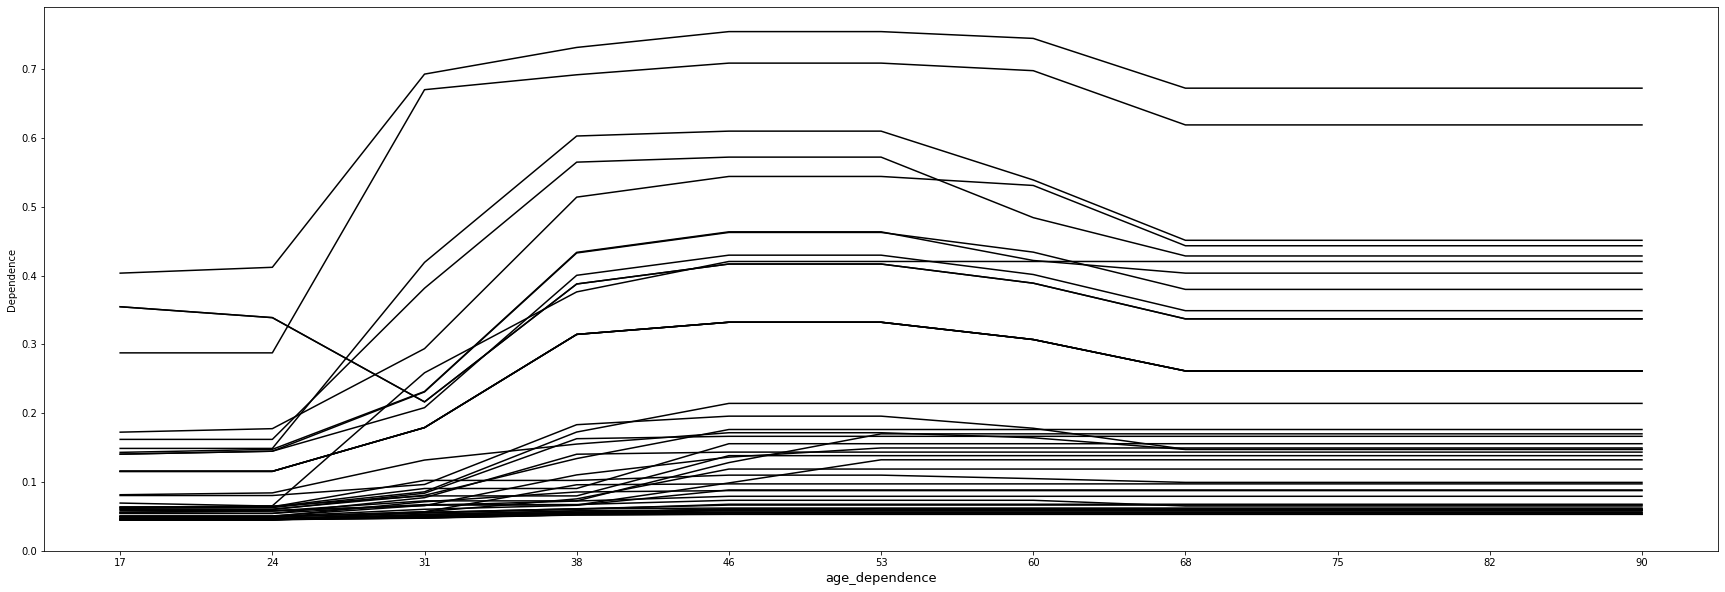

In [0]:
age_dep = get_pandas_df_from_column(output, 'age_dependence')

plot_ice_numeric(age_dep, col_name, figsize=(30, 10))

Helper function

In [0]:
def overlay_ice_with_pdp(df_ice, df_pdp, col, col_int=True, figsize=(20, 5)):
  dict_values = defaultdict(list)
  col_names_ice = list(df_ice.columns)
  num_instances = df_ice.shape[0]
  
  instances_y = {}
  i = 0

  for col_name in col_names_ice:
    for i in range(num_instances):
      dict_values[i].append(df_ice[col_name][i].toArray()[0])
  
  fig = plt.figure(figsize = figsize)
  for i in range(num_instances):
    plt.plot(col_names_ice, dict_values[i], "k")
    
  dict_values_pdp = {}
  col_names = list(df_pdp.columns)

  for col_name in col_names:
    dict_values_pdp[col_name] = df_pdp[col_name][0].toArray()[0]
    marklist= sorted(dict_values_pdp.items(), key=lambda x: int(x[0]) if col_int else x[0]) 
    sortdict=dict(marklist)
  
  plt.plot(col_names_ice, list(sortdict.values()), "r", linewidth=5)
  
  
  
  plt.xlabel(col, size=13)
  plt.ylabel("Dependence")
  plt.ylim(0.0)
  plt.show()
  

This shows how PDP visualizes the average dependence. Red line - PDP plot, black lines - ICE plots

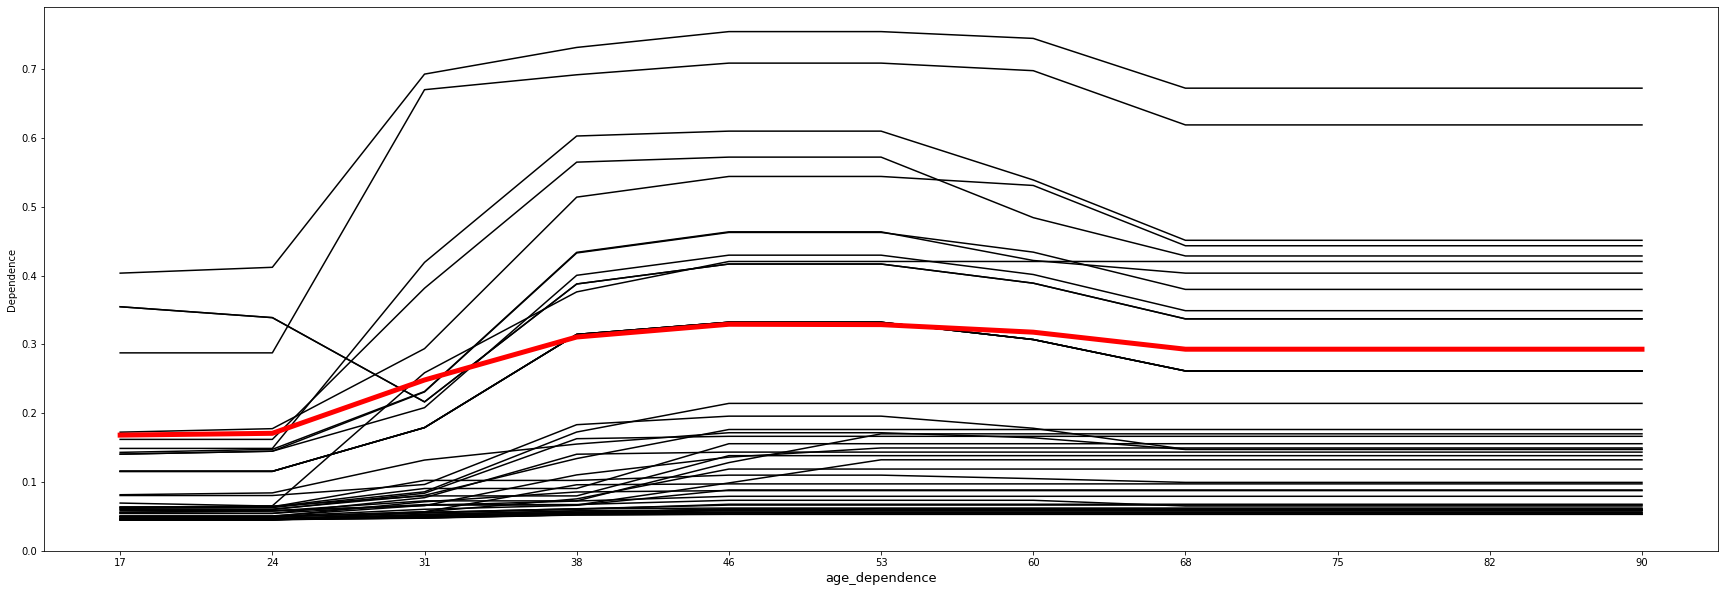

In [0]:
age_df_ice = get_pandas_df_from_column(output, 'age_dependence')
age_df_pdp = get_pandas_df_from_column(output_pdp, 'age_dependence')

overlay_ice_with_pdp(age_df_ice, age_df_pdp, col='age_dependence', figsize=(30, 10))

#### Example 2: Categorical feature: "occupation"

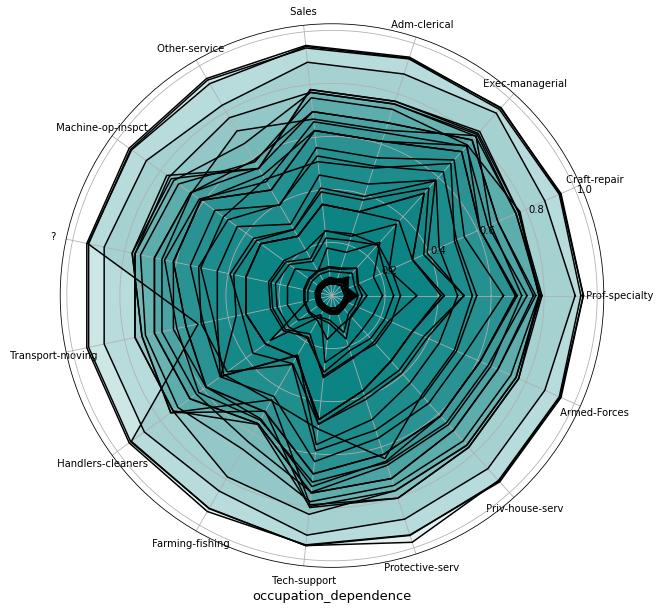

In [0]:
occupation_dep = get_pandas_df_from_column(output, 'occupation_dependence')


plot_ice_categorical(occupation_dep, col_name, figsize=(30, 10))

### Conclusions


**Advantages:**

1) Plots are intuitive to understand. One line represents the predictions for one instance if we vary the feature of interest.

2) ICE curves can uncover more complex relationships.

**Disadvantages:**

1) ICE curves can only display one feature meaningfully - otherwise you should overlay multiple surfaces.

2) Some points in the lines might be invalid data points according to the joint feature distribution. It causes by correlations between features.

3) In ICE plots it might not be easy to see the average.

## Summary

Partial dependence plots (PDP) and Individual Conditional Expectation (ICE) plots can be used to visualize and analyze interaction between the target response and a set of input features of interest.

Both PDPs and ICEs assume that the input features of interest are independent from the complement features, and this assumption is often violated in practice.

ICE shows the dependence on average, but if you want to observe features individually - you can use ICE.

Using examples above we showed how it can be usefull to draw such plots to analyze how machine learning model made their predictions, what was important and how we can interpret the results.